# Collective search on NK landscapes

In [81]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import pickle

In [86]:
class NK_landscape():
    
    def __init__(self, N=8, K=3, C = None, dependencies = None):
        assert N >= K+1
        
        self.N = N
        self.K = K
        
        if C is None or dependencies is None:
            self.initialize_C()
            self.initialize_dependencies()
        else:
            self.dependencies = dependencies
            self.C = C

        
        self.combinations = np.array(list(product([0,1], repeat=K+1)))
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = {}
        
        self.init_values()
        
    
    def initialize_dependencies(self):
        """[:,0] is connected with [:,1] --> [0,1] would mean node 0 has fluence on node 1"""
        depend = np.zeros((self.N, self.K+1))
        x = np.arange(self.N)
        depend[:,0] = x
        for _ in range(self.K):
            depend[:,_+1] = np.roll(x,_+1)

        self.dependencies = depend.astype(int)
    
    def initialize_C(self):
        self.C = np.random.random((self.N,2**(self.K+1))).round(1)

    def f(self, state):
        assert len(state) == self.N
        solution = []
        for i in range(len(self.dependencies)):
            for j, comb in enumerate(self.combinations):
                if ([state[self.dependencies[i][_]] for _ in range(self.K+1)] == comb).all():
                    solution.append(self.C[i][j])
        
        return solution, round(np.array(solution).mean(), 2)
    
    def init_values(self):
        max_val = 0
        min_val = 2
        for sol in np.array(list(product([0,1], repeat=self.N))):
            key = int("".join(map(str, sol)), 2)
            value = self.f(sol)[1]
            self.fitness_dict[key] = value
          
            if max_val < value:
                max_val = value
            if min_val > value:
                min_val = value
        self.max_value = max_val
        self.min_value = min_val
        
       
    def get_scaled_fitness(self, state):
        key = int("".join(map(str, state)), 2)
        value = self.fitness_dict[key]
        return np.round((value - self.min_value) / (self.max_value - self.min_value), 2)

In [87]:
class NK_landscape_loaded(NK_landscape):
    
    def __init__(self, N, K, fitness_dict):
        assert N >= K+1
        
        self.N = N
        self.K = K

        
        self.max_value = None
        self.min_value = None
        
        self.fitness_dict = fitness_dict
        self.init_min_max()
                
    
    def f(self, state):
        raise NotImplementedError("Only dictionary in loaded nk landscape")
        
    
    def init_min_max(self):
        self.max_value = max(self.fitness_dict.values())
        self.min_value = min(self.fitness_dict.values())
        

In [ ]:
file = 'N10K5_30.pkl' # N=10, K=5, 30 landscapes (0-29 )
# with open(file, 'rb') as f:
    # landscapes = pickle.load(f)

### Collective Hill Climbing

Several changes to the current state are assessed and a softmax decides which gets implemented

- No real agents yet
- Not voting
- No features


In [66]:
def softmax(values, b=5, axis=0):
    p = np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1,1)
    if axis == 0:
        return p[0]
    return np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1,1)

def bit_switch(digit, state):
    if state[digit] == 1:
        state[digit] = 0
    else:
        state[digit] = 1
    return state

In [118]:
rng = np.random.default_rng(0)


In [67]:
iterations = 100
N, K = 10, 5

n_agents = 7

env = NK_landscape(N, K)


In [70]:
state = np.round(rng.random(env.N)).astype(int)
state

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [76]:
def run(env, iterations, rng):
    """Consider Multiple changes and softmax with annealing for choice"""
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score

    for i in range(iterations):
        # every agents changes a random bit
        digits = rng.integers(0, N, n_agents)

        # Evaluate changes
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        # Softmax decides which to implement
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        # print(p_proposals)
        change_digit = rng.choice(np.arange(n_agents), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [161]:
rng = np.random.default_rng(0)


iterations = 100
n_trials = 300
N, K = 10, 5


score_tracker = np.empty((n_trials, iterations+1))
env = NK_landscape(N, K)
env.brute_force_max()

for i in range(n_trials):
    score_tracker[i] = run(env, iterations, rng)
    if i%50 == 0:
        print(i)

0
50
100
150
200
250


Text(0.5, 1.0, 'Considering Multiple changes')

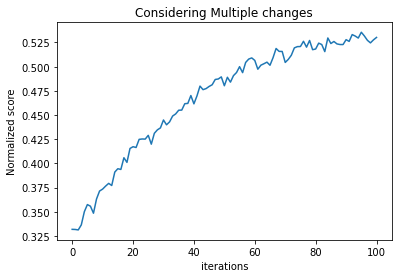

In [167]:
plt.plot(score_tracker.mean(axis=0))
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title("Considering Multiple changes")

## Information receiving Collective Search

#### Agents Features
**Information distribution for agents**
Agents have a personality feature which corresponds to the bits they are can change $\rho \in [0,1]$ sampled from $\mathbf{U}(0,1)$. The bit is sampled from $\mathbf{N}(\rho, 0.2)$, rounded and multiplied by 10. This means with $\rho = 0.2$ a gaussian with mean 0.2 is sampled and the result (likely 0.2) is used to define the bit (which would be 2)


**Communication ability**
Agents have a feature $\gamma$ which is the probability of receiving information about the proposed change of another agent. This means agents with high $\gamma$ have more knowledge of possible improvements.


**Performance Judgement**
Additional every agent has an attribute $\eta$ which models the competency of leading. After agents collect their information they assess which change they would propose if they are to decide the change. Some exploit their knowledge and choose the best, whereas others may have the information but do not know how to use it.


#### Schedule
1. Every agents makes local search in their knowledge area
2. Agents communicate by receiving information of others
3. Everyone Votes for one Agent to propose a change, based on their social influence
4. Changes to the team performance is made
5. Agents reinforce (positive or negative) the social influence of the speaker based on the performance difference

**Optimization**
- Stochatic Hill Climbing with inverse temperature

**Learning**
- Agents with high communication and good judgement should bring better proposals to the team and therefore emerge as leaders over time
- Rescola Wagner RL based on performance differences

Implementation Steps:
* [x] Agents draw a change randomly and softmax over the solutions decide which one gets picked
* [ ] Add communication feature and always draw the same agent (n-1 agents random feature, 1 agent set high or low)
    * Feature: Probability of receiving information
    * [ ] Check difference in performance between high and low feature agent 
(* [ ] Test Skill feature as well)
* [ ] Introduce weights to estimate social influence
    * [ ] Add feature based RL
    * [ ] Unbounded/ Bounded RL
* [ ] Introduce information distribution based on feature

#### Load nk landscapes form file

In [90]:
file = 'N10K5_30.pkl' # N=10, K=5, 30 landscapes (0-29 )
with open(file, 'rb') as f:
    landscapes = pickle.load(f)

In [91]:
rng = np.random.default_rng(0)

In [92]:
def run_f(env, f_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= f_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [99]:
rng = np.random.default_rng(0)
iterations = 100
n_trials = 500
N, K = 10, 5

n_agents = 7

# Communication feature of one agent
f_high = 0.8
f_low = 0.2
score_f_high = np.empty((n_trials, iterations+1))
score_f_low = np.empty((n_trials, iterations+1))


for i in range(n_trials):
    landscapes[rng.integers(0, 30)]
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0,30)])
    
    score_f_high[i] = run_f(env, f_high, iterations, rng)
    score_f_low[i] = run_f(env, f_low, iterations, rng)
    if i%50 == 0:
        print(i)
     

0
50
100
150
200
250
300
350
400
450


Text(0.5, 1.0, 'Team Perfomance - Decider receives options with with P=f')

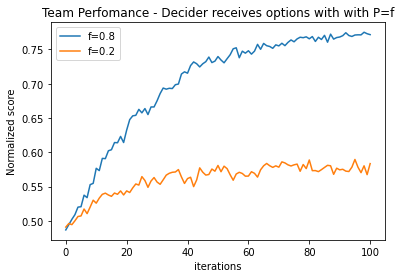

In [100]:
plt.plot(score_f_high.mean(axis=0), label="f=0.8")
plt.plot(score_f_low.mean(axis=0), label="f=0.2")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title("Team Perfomance - Decider receives options with with P=f")

In [104]:
def run_f_t(env, f_i, t_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= f_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations) * t_i) # ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores


In [101]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 300
N, K = 10, 5

n_agents = 7


# Communication feature of one agent
f = 0.8
t_low = 5
t_high = 20
score_t_high = np.empty((n_trials, iterations+1))
score_t_low = np.empty((n_trials, iterations+1))

print("Start")
for i in range(n_trials):
    landscapes[rng.integers(0,30)]
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0,30)])

    score_t_high[i] = run_f_t(env, f, t_high, iterations, rng)
    score_t_low[i] = run_f_t(env, f, t_low, iterations, rng)
    if i%50 == 0:
        print(i)
print("End")

Start
0
50
100
150
200
250
End


Text(0.5, 1.0, 'Team Perfomance - Inv. Temp of decider (f=0.8)')

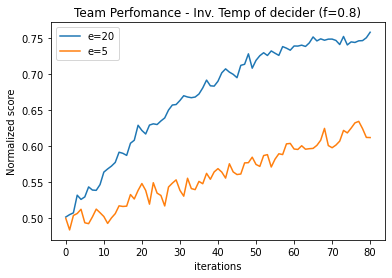

In [102]:
plt.plot(score_t_high.mean(axis=0), label="t=20")
plt.plot(score_t_low.mean(axis=0), label="t=5")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title("Team Perfomance - Inv. Temp of decider (f=0.8)")

### Check correlations of f and e

In [121]:
from scipy.stats.stats import pearsonr
import seaborn as sns

In [160]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
N, K = 10, 5

n_agents = 7


# Communication feature of one agent
results = np.empty((n_trials, 3))
f = 0.8
t = 30
print("Start")
for i in range(n_trials):
    landscapes[rng.integers(0,30)]
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0,30)])
    
    f, t = rng.random(2)
    # f = rng.random()
    run_scores = run_f_t(env, f, t, iterations, rng)
    
    results[i] = [f, t, run_scores.mean()]
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


Corr f and mean:  (0.01397270459684648, 0.7552895123737139)
Corr t and mean:  (0.07914966609640008, 0.07702990508638823)


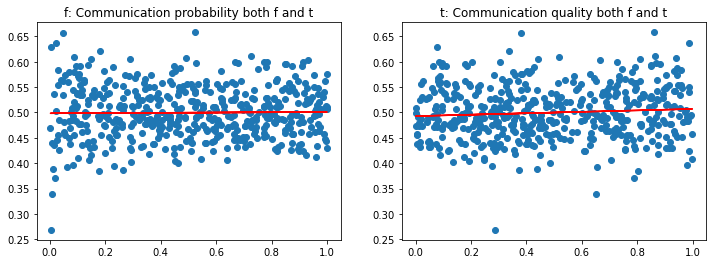

In [167]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

x = results[:,0]
y = results[:,2]
print("Corr f and mean: ", pearsonr(x, y))
axs[0].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[0].plot(x, m*x + c, 'r', label='Fitted line')
axs[0].set_title("f: Communication probability both f and t")


x = results[:,1]
y = results[:,2]
print("Corr t and mean: ", pearsonr(x, y))
axs[1].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[1].set_title("t: Communication quality both f and t")
axs[1].plot(x, m*x + c, 'r')

### Only using communication probability f

In [168]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
N, K = 10, 5

n_agents = 7


# Communication feature of one agent
results = np.empty((n_trials, 2))
f = 0.8
t = 30
print("Start")
for i in range(n_trials):
    landscapes[rng.integers(0,30)]
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0,30)])
    
    f = rng.random()
    run_scores = run_f_t(env, f, t, iterations, rng)
    
    results[i] = [f, run_scores.mean()]
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


Corr t and mean:  (0.7762960672037016, 7.253765625556705e-102)


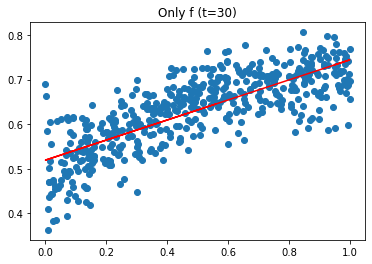

In [169]:
x = results[:,0]
y = results[:,1]
print("Corr t and mean: ", pearsonr(x, y))
plt.scatter(x, y)
m, c = np.polyfit(x, y, 1)
plt.title("Only f (t=30)")
plt.plot(x, m*x + c, 'r')

Clear correlation between communication and mean score

If the same agent with a high communication rate would be leader the performance would be good compared to low communication

--> Kick out temperature t as parameter as it only damages the quality of Communication probability

### First simple RL (without feature based RL)
f is now called gamma

In [291]:
def run_voting(env, gammas, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_scaled_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    
    t = 30
    social_influence = np.zeros((n_agents, n_agents))

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_scaled_fitness(search_state) for search_state in search_states])
        
        # Communication
        all_agent_scores = dict()
        all_agent_states = dict()
        for agent_i in range(n_agents):
            communication_index = rng.random(n_agents) <= gammas[agent_i]
            all_agent_scores[agent_i] = scores[communication_index]
            all_agent_states[agent_i] = search_states[communication_index]
        
        # Vote # TODO sofmax along axis
        p_votings = softmax(social_influence, 5, axis=1) # TODO: Which exploitation to use?
        votes = []
        for p in p_votings:
            votes.append(rng.choice(np.arange(n_agents), p=p))
        
        vote_agent_index, vote_count = np.unique(np.array(votes), return_counts=True)
        speaker = list(vote_count).index(max(vote_count))        # TODO: Always returns first index (if tie always the same gets chosen)
        
        # Applying solution
        if len(all_agent_scores[speaker]) == 0:
            # TODO Social update (if nothing happens)
            social_influence[:,speaker] = social_influence[:,speaker] + 0.2 * (score * 0.9 - score)
            all_scores[i+1] = score
            continue
        
        # Speaker draws from its known solutions
        scores = all_agent_scores[speaker]
        p_proposals = softmax(scores, ((i+1)/iterations) * t)
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # Update social influence
        
        social_influence[:,speaker] = social_influence[:,speaker] + 0.2 * (scores[change_digit] - score)
        
        state = all_agent_states[speaker][change_digit]
        score = scores[change_digit]
        
        
        all_scores[i+1] = score
    
    return social_influence.mean(axis=0)


In [302]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
N, K = 10, 5

n_agents = 7


# Communication feature of one agent
results = np.empty((n_trials*n_agents, 2))


print("Start")
for i in range(n_trials):
    landscapes[rng.integers(0,30)]
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0,30)])
    
    gammas = rng.random(n_agents)
    social_influence = run_voting(env, gammas, iterations, rng)
    
    results[i*n_agents : i*n_agents + n_agents][:,0] = gammas
    results[i*n_agents : i*n_agents + n_agents][:,1] = social_influence 
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


(0.5324635250104425, 1.4390258765586134e-255)


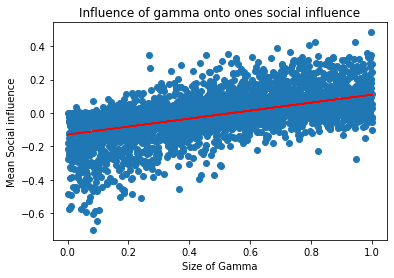

In [303]:
x = results[:,0]
plt.scatter(x, results[:,1])
m, c = np.polyfit(x,  results[:,1], 1)
plt.title("Influence of gamma onto ones social influence")
plt.plot(x, m*x + c, 'r')
plt.xlabel("Size of Gamma")
plt.ylabel("Mean Social influence")
print(pearsonr(x, results[:,1]))